# Feature selection with Mutual Information Scores

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

### Read the train dataset

In [2]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

## Seperate X and Y

In [5]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
Y = df[['Survived']]

In [6]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [7]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Seperate categorical and continuous features

In [8]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [9]:
cat

['Sex', 'Embarked']

In [10]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Create a feature selection Pipeline
1. cat - OrdinalEncoding

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [12]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [13]:
cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ordinal', OrdinalEncoder())])

In [14]:
pre1 = ColumnTransformer([('num', num_pipe1, con),
                          ('cat', cat_pipe1, cat)]).set_output(transform='pandas')

In [15]:
X_pre = pre1.fit_transform(X)
X_pre

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0
...,...,...,...,...,...,...,...
886,-0.369365,-0.181487,-0.474545,-0.473674,-0.386671,1.0,2.0
887,-1.566107,-0.796286,-0.474545,-0.473674,-0.044381,0.0,2.0
888,0.827377,-0.104637,0.432793,2.008933,-0.176263,0.0,2.0
889,-1.566107,-0.258337,-0.474545,-0.473674,-0.044381,1.0,0.0


### Visualise mutual information scores

In [16]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_pre, Y)
mi

array([0.04454148, 0.01573104, 0.05576129, 0.02190193, 0.14602298,
       0.15885852, 0.02235127])

In [17]:
mi = pd.Series(mi)
mi.index = X_pre.columns
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.158859
num__Fare        0.146023
num__SibSp       0.055761
num__Pclass      0.044541
cat__Embarked    0.022351
num__Parch       0.021902
num__Age         0.015731
dtype: float64

<Axes: title={'center': 'Mutual Information Scores'}>

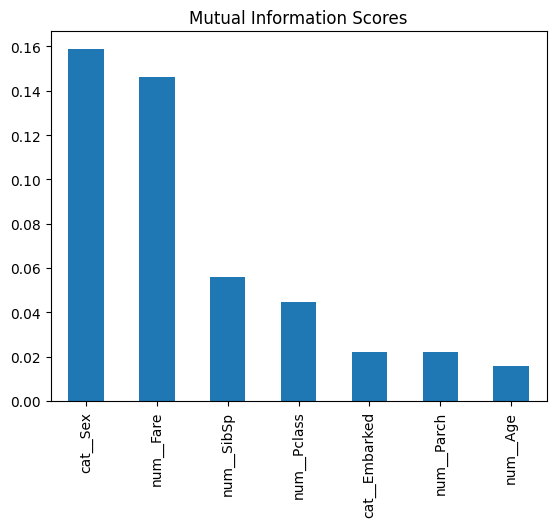

In [18]:
mi.plot(kind='bar', title='Mutual Information Scores')

### Select top k features

In [19]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel_feat = sel.fit_transform(X_pre, Y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Fare', 'cat__Sex'],
      dtype=object)

In [20]:
sel_cols[0]

'num__Pclass'

In [21]:
sel_cols[0].split('__')

['num', 'Pclass']

In [22]:
sel_cols[0].split('__')[1]

'Pclass'

In [23]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [24]:
imp_cols

['Pclass', 'Age', 'SibSp', 'Fare', 'Sex']

In [25]:
X_imp = X[imp_cols]
X_imp

,Pclass,Age,SibSp,Fare,Sex
0,3,22.0,1,7.2500,male
1,1,38.0,1,71.2833,female
2,3,26.0,0,7.9250,female
3,1,35.0,1,53.1000,female
4,3,35.0,0,8.0500,male
...,...,...,...,...,...
886,2,27.0,0,13.0000,male
887,1,19.0,0,30.0000,female
888,3,NaN,1,23.4500,female
889,1,26.0,0,30.0000,male


### Seperate Cat and con features

In [26]:
cat_sel = list(X_imp.columns[X_imp.dtypes=='object'])
con_sel = list(X_imp.columns[X_imp.dtypes!='object'])

In [27]:
cat_sel

['Sex']

In [28]:
con_sel

['Pclass', 'Age', 'SibSp', 'Fare']

## Create a final pipeline 
Cat -  OneHotEncoder

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
num_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [31]:
cat_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [32]:
pre2 = ColumnTransformer([('num', num_pipe2, con_sel),
                          ('cat', cat_pipe2, cat_sel)]).set_output(transform='pandas')

In [33]:
X_sel_pre = pre2.fit_transform(X_imp)
X_sel_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,-0.565736,0.432793,-0.502445,0.0,1.0
1,-1.566107,0.663861,0.432793,0.786845,1.0,0.0
2,0.827377,-0.258337,-0.474545,-0.488854,1.0,0.0
3,-1.566107,0.433312,0.432793,0.420730,1.0,0.0
4,0.827377,0.433312,-0.474545,-0.486337,0.0,1.0


### Apply train test split

In [34]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_sel_pre, Y, test_size=0.2, random_state=42)

In [35]:
xtrain.shape

(712, 6)

In [36]:
xtest.shape

(179, 6)

### Create a Random forest model

In [46]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(xtrain, ytrain)

RandomForestClassifier()

In [47]:
model.score(xtrain, ytrain)

0.9775280898876404

In [48]:
model.score(xtest, ytest)

0.7988826815642458

### Hyperparameter tuning

In [49]:
params = {'n_estimators':[10, 50, 100, 200],
          'max_depth':[2, 3, 4, 5],
          'min_samples_split':[5, 6, 7, 8]}

In [50]:
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestClassifier()
rscv = RandomizedSearchCV(rfc, param_distributions=params, scoring='f1_macro')
rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 3, 4, 5],
                                        'min_samples_split': [5, 6, 7, 8],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='f1_macro')

In [51]:
rscv.best_params_

{'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 5}

In [52]:
rscv.best_score_

0.814622293178622

In [53]:
best_rfc = rscv.best_estimator_
best_rfc

RandomForestClassifier(max_depth=5, min_samples_split=7, n_estimators=200)

In [54]:
best_rfc.score(xtrain, ytrain)

0.8539325842696629

In [56]:
best_rfc.score(xtest, ytest)

0.7932960893854749

### Predict results for train and test

In [57]:
ypred_tr = best_rfc.predict(xtrain)
ypred_ts = best_rfc.predict(xtest)

In [58]:
ypred_tr[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [59]:
ytrain[0:5]

,Survived
331,0
733,0
382,0
704,0
813,0


In [60]:
ytest[0:5]

,Survived
709,1
439,0
840,0
720,1
39,1


In [61]:
ypred_ts[0:5]

array([0, 0, 0, 1, 0], dtype=int64)

### Create a confusion matrix

In [62]:
c = best_rfc.classes_
c

array([0, 1], dtype=int64)

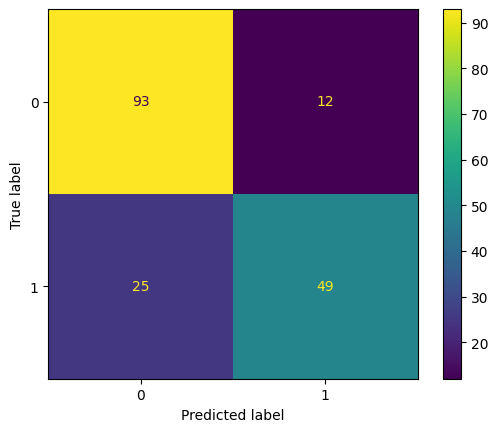

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

### Print the classification Report

In [64]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       105
           1       0.80      0.66      0.73        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



### Predicting out of sample data

In [66]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [67]:
pre2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex'])])

In [68]:
xnew_pre = pre2.transform(xnew)
xnew_pre

,num__Pclass,num__Age,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,0.394887,-0.474545,-0.490783,0.0,1.0
1,0.827377,1.355510,0.432793,-0.507479,1.0,0.0
2,-0.369365,2.508257,-0.474545,-0.453367,0.0,1.0
3,0.827377,-0.181487,-0.474545,-0.474005,0.0,1.0
4,0.827377,-0.565736,0.432793,-0.401017,1.0,0.0
...,...,...,...,...,...,...
413,0.827377,-0.104637,-0.474545,-0.486337,0.0,1.0
414,-1.566107,0.740711,-0.474545,1.544246,1.0,0.0
415,0.827377,0.702286,-0.474545,-0.502445,0.0,1.0
416,0.827377,-0.104637,-0.474545,-0.486337,0.0,1.0


### Predict results for above

In [69]:
preds = best_rfc.predict(xnew_pre)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [71]:
prob = best_rfc.predict_proba(xnew_pre)[:,1]
prob

array([0.10678362, 0.38915233, 0.14982534, 0.13221727, 0.51764453,
       0.15070625, 0.64252555, 0.16390865, 0.64517302, 0.11906205,
       0.11467119, 0.20847363, 0.95611678, 0.15669614, 0.97550169,
       0.92425108, 0.11819748, 0.13057117, 0.46615249, 0.48994097,
       0.30421627, 0.36779862, 0.92458743, 0.29818859, 0.93363277,
       0.11676409, 0.95947776, 0.1311089 , 0.3277471 , 0.11785086,
       0.14130123, 0.17308459, 0.59657273, 0.40739527, 0.37439883,
       0.13236243, 0.48381428, 0.4441677 , 0.12611962, 0.33141411,
       0.11583523, 0.30628167, 0.10222655, 0.9311844 , 0.97550169,
       0.13974585, 0.29935396, 0.11712762, 0.9634585 , 0.64931098,
       0.33026792, 0.13713464, 0.90366387, 0.87312377, 0.13866862,
       0.09598642, 0.105056  , 0.12010754, 0.13042722, 0.97658435,
       0.12481651, 0.12875449, 0.12930139, 0.65803081, 0.42284271,
       0.90815374, 0.55239485, 0.26196329, 0.29135525, 0.92695526,
       0.62484361, 0.1227869 , 0.55148271, 0.28974389, 0.97827

### Create a final dataframe

In [72]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [73]:
df_final['Survived_pred'] = preds
df_final['Survived_prob'] = prob

In [74]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.106784
1,893,0,0.389152
2,894,0,0.149825
3,895,0,0.132217
4,896,1,0.517645
...,...,...,...
413,1305,0,0.120504
414,1306,1,0.982929
415,1307,0,0.095465
416,1308,0,0.120504


In [75]:
df_final['Survived_prob'] = df_final['Survived_prob'].apply(round, args=(4,))

In [76]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.1068
1,893,0,0.3892
2,894,0,0.1498
3,895,0,0.1322
4,896,1,0.5176
...,...,...,...
413,1305,0,0.1205
414,1306,1,0.9829
415,1307,0,0.0955
416,1308,0,0.1205


In [78]:
df_final['Survived_pred'].value_counts()

Survived_pred
0    281
1    137
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

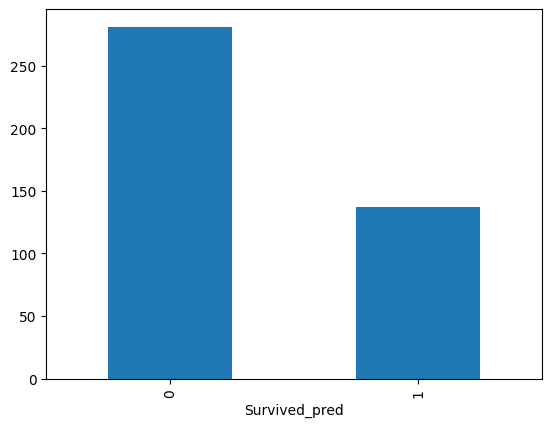

In [79]:
df_final['Survived_pred'].value_counts().plot(kind='bar')

### Save above to results.csv

In [77]:
df_final.to_csv('Results.csv', index=False)